# FIR to IIR with the help for IIR_Test.ipynb


In this Notebook, I start with a given example from migen and try to convert it into a synthesizable IIR Filter. <br>
The given example can be found here: https://github.com/m-labs/migen/blob/master/examples/sim/fir.py <br>
I modified the given example a little bit to make things better visible <br>


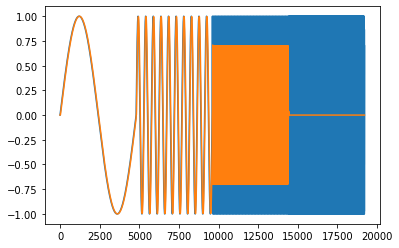

In [6]:
from functools import reduce
from operator import add

from math import cos, pi
from scipy import signal
import matplotlib.pyplot as plt

from migen import *
from migen.fhdl import verilog
import numpy

sample = 4800       #Number of Samples
Fs = 4800           #Sample Frequ
fc = 100           #Cutoff Frequ
w_c = 2*fc/Fs       #Digital Frequ
n = 40               #Order


# A synthesizable FIR filter.
class FIR(Module):
    def __init__(self, coef, wsize=32):
        self.coef = coef
        self.wsize = wsize
        self.i = Signal((self.wsize, True))
        self.o = Signal((self.wsize, True))

        ###

        muls = []
        src = self.i
        for c in self.coef:
            sreg = Signal((self.wsize, True))
            self.sync += sreg.eq(src)
            src = sreg
            c_fp = int(c*2**(self.wsize - 1))
            muls.append(c_fp*sreg)
        sum_full = Signal((2*self.wsize-1, True))
        self.sync += sum_full.eq(reduce(add, muls))
        self.comb += self.o.eq(sum_full >> self.wsize-1)


# A test bench for our FIR filter.
# Generates a sine wave at the input and records the output.
def fir_tb(dut, frequency, inputs, outputs):
    f = 2**(dut.wsize - 1)
    x = numpy.arange(sample)
    for x in x:
        y = 0.1*numpy.sin(2 * numpy.pi * frequency * x / Fs)
        yield dut.i.eq(int(f*y))
        inputs.append(y*10)
        outputs.append((yield dut.o)/f*10)
        yield
    yield


if __name__ == "__main__":
    # Compute filter coefficients with SciPy.
    #coef = signal.remez(30, [0, 0.1, 0.2, 0.4, 0.45, 0.5], [0, 1, 0])
    coef = signal.firwin(n, cutoff = w_c, window = "hanning", pass_zero='lowpass')
    #print(coef)
    # Simulate for different frequencies and concatenate
    # the results.
    in_signals = []
    out_signals = []
    for frequency in [1,10,100,1000]:
        dut = FIR(coef)
        tb = fir_tb(dut, frequency, in_signals, out_signals)
        run_simulation(dut, tb)

    # Plot data from the input and output waveforms.
    plt.plot(in_signals)
    plt.plot(out_signals)
    plt.show()



The given code can be converted into a Verilog file with the command:

In [7]:
    # Print the Verilog source for the filter.
    fir = FIR(coef)
    print(verilog.convert(fir, ios={fir.i, fir.o})) #too much to display here

/* Machine-generated using Migen */
module top(
	input signed [31:0] i,
	output signed [31:0] o,
	input sys_clk,
	input sys_rst
);

reg signed [31:0] sreg0 = 32'sd0;
reg signed [31:0] sreg1 = 32'sd0;
reg signed [31:0] sreg2 = 32'sd0;
reg signed [31:0] sreg3 = 32'sd0;
reg signed [31:0] sreg4 = 32'sd0;
reg signed [31:0] sreg5 = 32'sd0;
reg signed [31:0] sreg6 = 32'sd0;
reg signed [31:0] sreg7 = 32'sd0;
reg signed [31:0] sreg8 = 32'sd0;
reg signed [31:0] sreg9 = 32'sd0;
reg signed [31:0] sreg10 = 32'sd0;
reg signed [31:0] sreg11 = 32'sd0;
reg signed [31:0] sreg12 = 32'sd0;
reg signed [31:0] sreg13 = 32'sd0;
reg signed [31:0] sreg14 = 32'sd0;
reg signed [31:0] sreg15 = 32'sd0;
reg signed [31:0] sreg16 = 32'sd0;
reg signed [31:0] sreg17 = 32'sd0;
reg signed [31:0] sreg18 = 32'sd0;
reg signed [31:0] sreg19 = 32'sd0;
reg signed [31:0] sreg20 = 32'sd0;
reg signed [31:0] sreg21 = 32'sd0;
reg signed [31:0] sreg22 = 32'sd0;
reg signed [31:0] sreg23 = 32'sd0;
reg signed [31:0] sreg24 = 32'sd0;
reg

## Expand the FIR
The given input function is not really what i want. Therefore i decided to change it to the "chirp" function, which I allready used in the IIR_Test.ipynb. <br>
The "chirp" function generates an array that contains multiple sine waves with growing frequency.<br>
I also started to go away from the max word size (self.size-1) and started to use the "Exponent", which will be useful for the IIR implementation later.

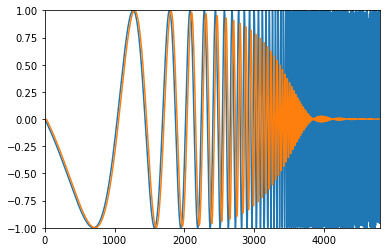

In [8]:
from functools import reduce
from operator import add

from math import cos, pi
from scipy import signal
import matplotlib.pyplot as plt

from migen import *
from migen.fhdl import verilog
import numpy
from scipy.signal import chirp

sample = 4800       #Number of Samples
Fs = 4800           #Sample Frequ
fc = 10           #Cutoff Frequ
w_c = 2*fc/Fs       #Digital Frequ
n = 40               #Order
Expmin = 16       #Exponent for the Fixpoint conversion


# A synthesizable FIR filter.
class FIR(Module):
    def __init__(self, coef, Exponent=16, wsize=32):
        self.coef = coef
        self.wsize = wsize
        self.i = Signal((self.wsize, True))
        self.o = Signal((self.wsize, True))

        ###

        muls = []
        src = self.i
        for c in self.coef:
            sreg = Signal((self.wsize, True))
            self.sync += sreg.eq(src)
            src = sreg
            c_fp = int(c*2**(Exponent))
            muls.append(c_fp*sreg)
        sum_full = Signal((2*self.wsize-1, True))
        self.sync += sum_full.eq(reduce(add, muls))
        self.comb += self.o.eq(sum_full >> Exponent)


# A test bench for our FIR filter.
# Generates a sine wave at the input and records the output.
def fir_tb(dut,Exponent, inputs, outputs):
    f = 2**Exponent
    input = chirp(t=numpy.linspace(0, 1, sample), f0=1, f1=1000, t1=1, method='logarithmic',phi = 90)
    for x in input:
        #y = numpy.sin(2 * numpy.pi * frequency * x / Fs)
        yield dut.i.eq(int(x*f))
        inputs.append(x)
        outputs.append((yield dut.o)/f)
        yield
    yield


if __name__ == "__main__":
    # Compute filter coefficients with SciPy.
    #coef = signal.remez(30, [0, 0.1, 0.2, 0.4, 0.45, 0.5], [0, 1, 0])
    coef = signal.firwin(n, cutoff = w_c, window = "hanning", pass_zero='lowpass')
    #print(coef)
    # Simulate for different frequencies and concatenate
    # the results.
    in_signals = []
    out_signals = []
    dut = FIR(coef)
    tb = fir_tb(dut, Expmin, in_signals, out_signals)
    run_simulation(dut, tb)

    # Plot data from the input and output waveforms.
    plt.axis([0, 4800, -1, 1])
    plt.plot(in_signals)
    plt.plot(out_signals)
    plt.show()


If you want too see interesting things, try to change the interal word size, which is called "Expmin" to smaller number like (2 to 6). <br>
If you scale the "Expmin" above 31 numerical overflows will take place and the results will be, let's say interesting.


## FIR to IIR:


In this step happens a lot. <br>
* The coefficients are now calculated for iir-filter and called coefa and coefb
* The names of the Filter and its testbench changed to iir
* The function "Multiplyer" as well as the function "minExp" from IIR_Test.ipynb are used
* New imports are needed
* The verilog print now takes the arguments (coefa, coefb, Expmax, wsize)
* The FIR Filter gets replaced by the class IIR(Module)
* The IIR Filter takes the arguments (coefa, coefb, Expmax, wsize) <br>
... and many more

The function "minExp" takes the coefficients and gives back the min and the max possible coefficient. <br>
Obviously, it is best to count on the maximum coefficient for the accuracy of the result. <br>
However, if storage space is to be saved, or if only limited adders and multipliers are available, it makes sense to move further in the direction of the minimum coefficient. <br>
With the "Type" you can define your max internal wordsize of the coefficients or the input signal -> possible are: int16, int32 and int64 <br>
With wsize can you define your max internal register size. !!!For some internal summations, bigger registers will be generated through the Filter Module!!!

### IIR-Filter direct form 1: 

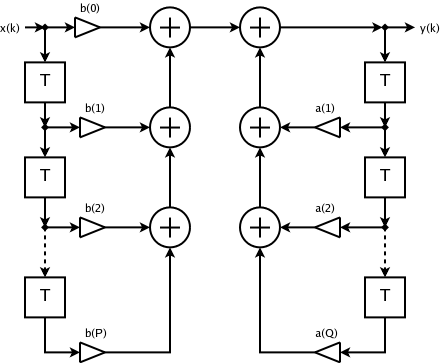

In [35]:
from IPython.display import Image
Image("img/BlockIIRFilter.png")

Expmin = 
 8
None
Expmax = 
 31
None


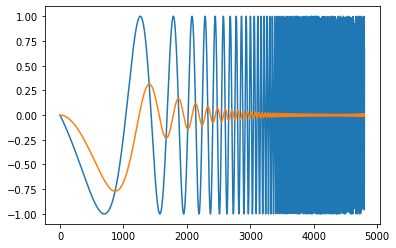

In [11]:
from functools import reduce
from operator import add

from math import cos, pi
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

from migen import *
from migen.fhdl import verilog
import numpy
from scipy.signal import chirp
from scipy import signal
import scipy.signal as sig
import math

### Create the filter #######################
frequency = 100
Fs = 4800           #Sample Frequ
samples = 4800       #Number of Samples
f = 100             #Sig gen Frequ
n = 1               #Order of Filter
rs = 30             #only for Cheby
fc = 10            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Type = "int32"      #Type of the internal calc
wsize = 32          #Wordlength
#########################################################

### Find the smallest possible Exponent out of coefa and coefb ###########
def minExp (lista,listb,maxsize):
    if maxsize == "int16":
        maxsize = 16
    elif maxsize == "int32":
        maxsize = 32
    elif maxsize == "int64":
        maxsize = 64
    else:
        raise TypeError("The Exponent must be an Integer")
    lista =  [abs(ele) for ele in lista]                            #Generates a List of absolute Values
    listb =  [abs(ele) for ele in listb]                            #Generates a List of absolute Values
    minall = min(min(lista), min(listb))                            #find the minimum of the two new lists
    maxall = max(max(lista), max(listb))                            #find the maximum of the two new lists
    Expmin = int(round(0.49 + math.log(1/minall, 2)))               #find the minimum Exponent
    Expmax = int(round(math.log((2**(maxsize-1))/maxall, 2)))       #find the maximum Exponent
    print(print("Expmin = \n", Expmin))
    print(print("Expmax = \n", Expmax))
    if Expmin > Expmax:
        raise OverflowError("Filter is not possible, enlarge the internal Register or define the specs in another way")
    return Expmin,Expmax                                            #return this two found Exponents
#########################################################################

### Used to do test for the needed Exponent##############################
def Multiplyer (coefa,coefb,Exponent):
    for c in range(len(coefa)):
        coefa[c] = np.int(coefa[c]*2**Exponent)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefa = coefa.astype(Type)
    for c in range(len(coefb)):
        coefb[c] = int(coefb[c]*2**Exponent)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefb = coefb.astype(Type)
    return coefa,coefb
########################################################################

# A synthesizable FIR filter.
class IIR(Module):
    def __init__(self, coefa,coefb, Exponent=16, wsize=32):
        coefa[0] = 0
        self.coefa = coefa
        self.coefb = coefb
        self.wsize = wsize
        self.i = Signal((self.wsize, True))
        self.o = Signal((self.wsize, True))

        ###

        mulsb = []
        mulsa = []

        sum_fulla = Signal((2*self.wsize-1, True))
        sum_fullb = Signal((2*self.wsize-1, True))
        sum_full = Signal((2*self.wsize-1, True))

        srcb = self.i

        for c in self.coefb:
            sregb = Signal((self.wsize, True))      #Generate a new signal
            self.sync += sregb.eq(srcb)             #sregb = srcb
            srcb = sregb
            mulsb.append(int(c)*sregb)
        self.sync += sum_fullb.eq(reduce(add, mulsb))
        self.sync += sum_full.eq((sum_fullb-sum_fulla)>>(Exponent))    #Both summations are devided by Exponent

        srca = sum_full                           #the source is now the output

        for c in self.coefa:                        #same as above just with another source
            srega = Signal((self.wsize, True))
            self.sync += srega.eq(srca)
            srca = srega
            mulsa.append(int(c)*srega)

        self.sync += sum_fulla.eq(reduce(add, mulsa))
        self.comb += self.o.eq(sum_full)


####################Testbench###########################################
def iir_tb(dut,Exponent, inputs, outputs):
    f = 2**Exponent
    input = chirp(t=numpy.linspace(0, 1, samples), f0=1, f1=1000, t1=1, method='logarithmic',phi = 90)
    for x in input:
        yield dut.i.eq(int(x*f))
        inputs.append(x)
        outputs.append((yield dut.o)/f)
        yield
    yield
################################################################

if __name__ == "__main__":
    [coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")
    Expmin,Expmax = minExp(coefa,coefb,Type)
    [coefa,coefb] = Multiplyer(coefa,coefb,Expmax)

    in_signals = []
    out_signals = []
    dut = IIR(coefa,coefb,Expmax,wsize)
    tb = iir_tb(dut, Expmax, in_signals, out_signals)
    run_simulation(dut, tb)

    # Plot data from the input and output waveforms.
    plt.plot(in_signals)
    plt.plot(out_signals)
    plt.show()

    # Print the Verilog source for the filter.
    #iir = IIR(coefa,coefb,Expmax,wsize)
    #print(verilog.convert(iir, ios={iir.i, iir.o}))


This looks pretty good, but if i change the Order of the filter i get strange results. ??